In [1]:
import os
import csv
import numpy as np
import pandas as pd

import scipy
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV,Lasso, LinearRegression
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.feature_selection import mutual_info_regression, RFE
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestRegressor,
                              GradientBoostingRegressor)
from sklearn.metrics import mean_squared_error, r2_score
pd.set_option("display.max_rows", 999)

import sys
sys.path.insert(0, '/Users/maceli/useful_functions')

from functions import *

sns.set_palette('husl')
sns.set_style("white")

In [2]:
listings=pd.read_csv('listings.csv')
sorted(listings)

['accommodates',
 'amenities',
 'availability_30',
 'availability_365',
 'availability_60',
 'availability_90',
 'bathrooms',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms',
 'calendar_last_scraped',
 'calendar_updated',
 'description',
 'first_review',
 'has_availability',
 'host_about',
 'host_acceptance_rate',
 'host_has_profile_pic',
 'host_id',
 'host_identity_verified',
 'host_is_superhost',
 'host_listings_count',
 'host_location',
 'host_name',
 'host_neighbourhood',
 'host_picture_url',
 'host_response_rate',
 'host_response_time',
 'host_since',
 'host_thumbnail_url',
 'host_total_listings_count',
 'host_url',
 'host_verifications',
 'id',
 'instant_bookable',
 'last_review',
 'last_scraped',
 'latitude',
 'license',
 'listing_url',
 'longitude',
 'maximum_maximum_nights',
 'maximum_minimum_nights',
 'maxi

Variaveis como listing_url, scrape,
Reviews: sao informacoes coletadas apos ser host
Informacoes relacionadas a localizacao, sabemos que e uma pra uma determinada cidade.
Tão informacoes nao serao consideradas.

__Step 1:__
Verificar a quantidade de missing nas variaveis

In [5]:
missing_data(listings)

,Total,Percent
neighbourhood_group_cleansed,34664,100.000000
calendar_updated,34664,100.000000
license,34664,100.000000
host_about,18113,52.253058
neighbourhood,17648,50.911609
neighborhood_overview,17648,50.911609
review_scores_value,8457,24.397069
review_scores_location,8455,24.391299
review_scores_communication,8455,24.391299
review_scores_checkin,8455,24.391299


__Step 2:__
Variaveis com mais de 40% de missing serao dropadas,exceto security_deposit que veremos o comportamento entre o preco e taxa.
Para as variaveis bathrooms, bedrooms and beds sera preenchido com a mediana  
Para host_identity_verified valores nullos serao dropados
Serao mantidas as seguintes variaveis[keep], as demais serao dropadas

In [7]:
keep=[

#host informations
'host_has_profile_pic',
'host_identity_verified',
'host_id' ,  
'host_verifications',    
#guest informations

#location
'neighbourhood_cleansed',
'latitude',
'longitude',
 
#informations about the rules
#'security_deposit',
#'cleaning_fee',

'price',
'minimum_nights',
'maximum_nights',
'instant_bookable',

 
#informations about the place
'bathrooms',
'beds',
'bedrooms',

'property_type',
'amenities',
'room_type',  
'accommodates',
  
]

In [8]:
listings=listings[keep]

In [9]:
listings['bathrooms'] = listings['bathrooms'].fillna(listings['bathrooms'].mode()[0])
listings['bedrooms'] = listings['bedrooms'].fillna(listings['bedrooms'].mode()[0])
listings['beds'] = listings['beds'].fillna(listings['beds'].mode()[0])
#listings['cleaning_fee_n'] = listings['cleaning_fee'].fillna(listings['cleaning_fee'].mode()[0])
#listings['security_deposit_n'] = listings['security_deposit'].fillna(listings['security_deposit'].mode()[0])

__Step 3:__
Verificar o tipo das variaveis

In [12]:
listings.dtypes

host_has_profile_pic       object
host_identity_verified     object
host_id                     int64
host_verifications         object
neighbourhood_cleansed     object
latitude                  float64
longitude                 float64
price                      object
minimum_nights              int64
maximum_nights              int64
instant_bookable           object
bathrooms                 float64
beds                      float64
bedrooms                  float64
property_type              object
amenities                  object
room_type                  object
accommodates                int64
dtype: object

__Step 4:__
Após verificar o tipo das variaveis, observa-se que variaveis que deveriam ser float, estao como objetc, e variaveis que deveriam ser int estao como float.
Neste passo, será feita esta correcao para as variaveis float e tbm int

In [20]:
listings['price'] = listings['price'].astype(str).str.replace("[$, ]", "").astype("float")
#listings['security_deposit_n'] = pd.to_numeric(listings['security_deposit_n'].apply(lambda x: str(x).replace('$', '').replace(',', '')),errors='coerce')
#listings['security_deposit_n'] = pd.to_numeric(listings['security_deposit_n'].apply(lambda x: str(x).replace('$', '').replace(',', '')),errors='coerce')
#listings['cleaning_fee'] = pd.to_numeric(listings['cleaning_fee'].apply(lambda x: str(x).replace('$', '').replace(',', '')),errors='coerce')
#listings['extra_people'] = pd.to_numeric(listings['extra_people'].apply(lambda x: str(x).replace('$', '').replace(',', '')),errors='coerce')
#listings['cleaning_fee_n'] = pd.to_numeric(listings['cleaning_fee_n'].apply(lambda x: str(x).replace('$', '').replace(',', '')),errors='coerce')
c = ['bathrooms','beds','bedrooms']
listings[c] = listings[c].astype("int64")

<ipython-input-20-36edb37df53e>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  listings['price'] = listings['price'].astype(str).str.replace("[$, ]", "").astype("float")


__Verificando outliers e inconsistencias__

__Step 5:__
Verificar a distribuicao das das variaveis

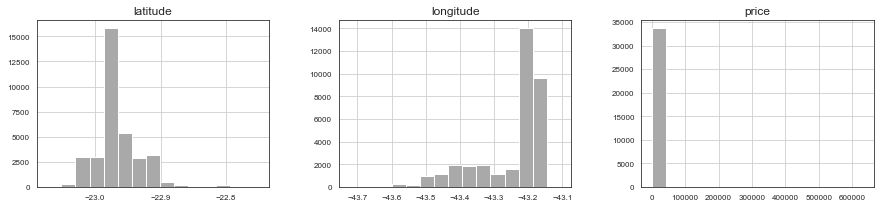

In [24]:

numerical=listings.select_dtypes(include='float64').columns.tolist()
listings[numerical].hist(bins=15, figsize=(15, 15), layout=(4, 3), xlabelsize=8, color='darkgrey', ylabelsize=8);

<AxesSubplot:xlabel='count', ylabel='bedrooms'>

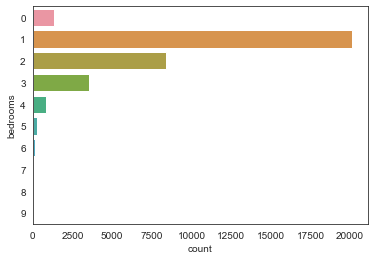

In [25]:
sns.countplot(y = 'bedrooms', data = listings,
              order = listings['bedrooms'].iloc[:10].index)  

<AxesSubplot:xlabel='count', ylabel='beds'>

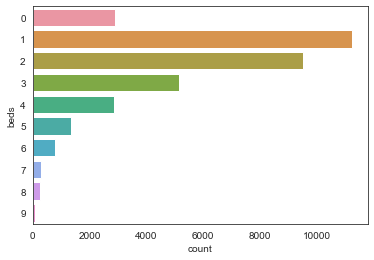

In [28]:
sns.countplot(y = 'beds', data = listings,
              order = listings['beds'].iloc[:10].index)    

<AxesSubplot:xlabel='count', ylabel='bathrooms'>

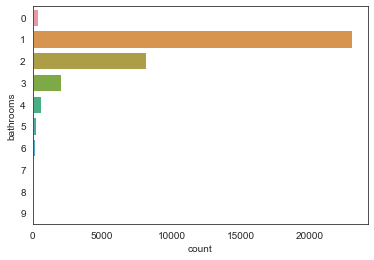

In [30]:
sns.countplot(y = 'bathrooms', data = listings,
              order = listings['bathrooms'].iloc[:10].index)  

In [32]:
cols = ['property_type']
listings[cols].apply(pd.Series.value_counts).iloc[:10]

,property_type
Entire rental unit,21966
Private room in rental unit,4101
Entire condo,1709
Entire home,1645
Private room in home,1193
Entire loft,731
Entire serviced apartment,729
Private room in condo,359
Room in hotel,262
Private room in bed and breakfast,260


In [34]:
cols = ['accommodates']
listings[cols].apply(pd.Series.value_counts).iloc[:10]

,accommodates
4,10160
2,9232
3,4078
6,3830
5,2701
1,1510
8,1119
7,665
10,528
16,229


In [36]:
cols = ['room_type']
listings[cols].apply(pd.Series.value_counts).iloc[:10]

,room_type
Entire home/apt,27383
Private room,6643
Shared room,613
Hotel room,25


In [38]:
cols = ['host_has_profile_pic']
listings[cols].apply(pd.Series.value_counts)

,host_has_profile_pic
t,33613
f,1051


In [40]:
cols = ['neighbourhood_cleansed']
listings[cols].apply(pd.Series.value_counts).iloc[:10]

,neighbourhood_cleansed
Copacabana,10783
Ipanema,3299
Barra da Tijuca,3242
Recreio dos Bandeirantes,1730
Leblon,1622
Jacarepaguá,1541
Botafogo,1466
Centro,1311
Santa Teresa,1116
Flamengo,795


__Step 6:__
Observando o graficos acima, especialmente na variável preco (histograma), que é nosso target, nota-se que os precos estao concentrados e ha indicois de valores outliers, para tomar algum tipo de decisao, será analisado a distriuicao e também um grafico boxplot.
Variaveis categoricas com pouca volumetria serao agrupadas

<AxesSubplot:>

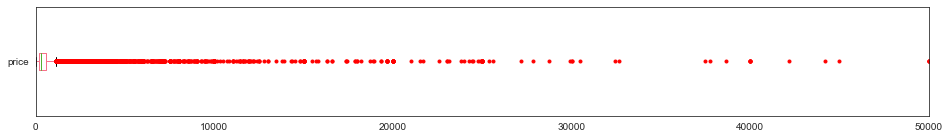

In [42]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
listings['price'].plot(kind='box', xlim=(0, 50000), vert=False, flierprops=red_square, figsize=(16,2))

In [44]:
listings['price'].describe()

count     33692.000000
mean        731.188235
std        5667.250477
min           0.000000
25%         199.000000
50%         307.000000
75%         572.000000
max      633125.000000
Name: price, dtype: float64

In [46]:
cv=listings['price'].std()/listings['price'].mean()
cv

7.750740792641598

__Step 7:__
O coeficente de variacao, cv aprox. 7.75 indica grande variabilidade dos dados, e pelo boxplot nota-se
a presenca de outliers.
Para o tratamentode outliers sera aplicado o interva-los interquartilicos.

In [49]:
#distance = 1.5 * (np.nanpercentile(listings['price'], 75) - np.nanpercentile(listings['price'], 25))
#lim_sup=distance + np.nanpercentile(listings['price'], 75)
#lim_sup

1131.5

In [51]:

listings.drop(listings[ (listings.price == 0) | (listings.price > lim_sup)].index, axis=0, inplace=True)

In [53]:
listings['price'].describe()

count    30283.000000
mean       356.730212
std        234.506310
min         33.000000
25%        189.000000
50%        286.000000
75%        463.000000
max       1130.000000
Name: price, dtype: float64

<AxesSubplot:>

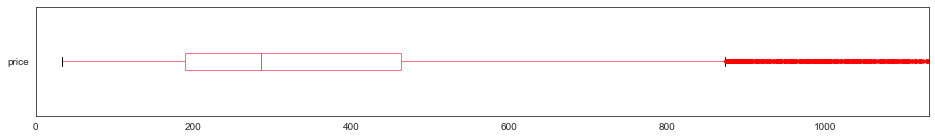

In [55]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
listings['price'].plot(kind='box', xlim=(0,lim_sup), vert=False, flierprops=red_square, figsize=(16,2))

In [57]:
cv=listings['price'].std()/listings['price'].mean()
cv

0.6573772056250702

In [193]:
listings.drop(listings[ (listings.beds ==0)  ].index, axis=0, inplace=True)
listings.drop(listings[ (listings.bathrooms ==0)  ].index, axis=0, inplace=True)
listings.dropna(subset=['host_has_profile_pic'])
listings.host_verifications.unique()

array(["['email', 'phone']", "['phone']",
       "['email', 'phone', 'work_email']", "['phone', 'work_email']",
       "['email', 'work_email']", "['email']", '[]'], dtype=object)

Para tratamento de outliers, foi removido baseado no intervalo interquartilico.
Analisamos algumas inconsistencias, como cama e banheiros zeradas, em relacao a quarto zerado obseva-se
este valores quando o tipo de propriedade é studio.

In [195]:
print("O dataset tem {} linhas e {} colunas - depois de pre-processo.".format(*listings.shape))

O dataset tem 28334 linhas e 26 colunas - depois de pre-processo.


__Construcao de novas variaveis e agrupamento de categorias com baixa volumetria__


__Step 8:__
   Variaveis como bairro, onde contem muitas categorias, sera mantida as 10 primeiras mais relevantes e as demais agrupadas.
  Serao criadas variavies, baseadas em amenities e host_verifications

In [189]:
# Encode multi-categorical variables to dummy variables (to avoid high cardinality and strange distributions)

# Function to return categories of columns based on threshold of distribution of the category
def one_hot(s, threshold,prefix):
    d = pd.get_dummies(s)
    f = pd.value_counts(s, sort=False, normalize=True) < threshold
    if f.sum() == 0:
        newSeries=d
    else:
        newSeries=d.loc[:, ~f].join(d.loc[:, f].sum(1).rename('Other'))
    newSeries=newSeries.add_prefix(prefix)
    return newSeries

# One hot encoding of all categories above 15% - all others categories to "Other"
cols = ['property_type']
for i in range(len(cols)):
    colToProcess = X[cols[i]].astype(str)
    procDF = one_hot(colToProcess, .05,cols[i]+'_')
    X.drop(columns=cols[i], inplace=True)
    X = pd.concat([X, procDF], axis=1)

/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [187]:
keep=['property_type']
X=listings[keep]

In [191]:
X

,property_type_Entire condo,property_type_Entire rental unit,property_type_Private room in rental unit,property_type_Other
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
34659,0,1,0,0
34660,0,1,0,0
34661,0,1,0,0
34662,0,1,0,0


In [157]:
cols = ['property_type']
listings[cols].apply(pd.Series.value_counts)

,property_type
Entire rental unit,17800
Private room in rental unit,3536
Entire condo,1488
Private room in home,1046
Entire home,941
Entire loft,693
Entire serviced apartment,644
Private room in condo,344
Private room in bed and breakfast,222
Shared room in rental unit,200


In [70]:
cols = ['new_nei']
listings[cols].apply(pd.Series.value_counts)

,new_nei
Copacabana,9115
Outros,6275
Ipanema,2592
Barra da Tijuca,2463
Recreio dos Bandeirantes,1363
Leblon,1273
Botafogo,1252
Jacarepaguá,1226
Centro,1103
Santa Teresa,982


In [72]:
#listings['bed_type_n']=np.where((listings.bed_type == 'Real Bed') ,1,0)
listings['room_type']=listings['room_type'].replace('Hotel room','Private room')


In [74]:
results = Counter()
listings['amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results.update)

results.most_common(50)

[(' Wifi', 22557),
 (' Dishes and silverware', 19548),
 (' Hot water', 19311),
 (' Hangers', 17649),
 (' Bed linens', 17544),
 (' Iron', 17442),
 (' Cooking basics', 16792),
 (' Kitchen', 16315),
 (' Microwave', 15472),
 (' Refrigerator', 15318),
 (' Elevator', 14890),
 (' Air conditioning', 14773),
 (' TV', 14399),
 (' Dedicated workspace', 13155),
 (' Hair dryer', 12607),
 (' Room-darkening shades', 11819),
 (' Washer]', 11496),
 (' Long term stays allowed', 10793),
 (' Extra pillows and blankets', 10566),
 (' Drying rack for clothing', 10330),
 (' Dining table', 10147),
 (' Essentials', 9979),
 ('[Essentials', 9544),
 ('[Kitchen', 9432),
 (' Self check-in', 9084),
 (' Cleaning products', 8952),
 (' Blender', 8920),
 (' Laundromat nearby', 8193),
 (' Oven', 8039),
 (' Coffee maker', 7969),
 (' Wine glasses', 7764),
 (' Free parking on premises', 7679),
 (' Stove', 7645),
 (' Beach access \\u2013 Beachfront', 7409),
 (' Pets allowed', 6989),
 (' Luggage dropoff allowed', 6816),
 (' Cl

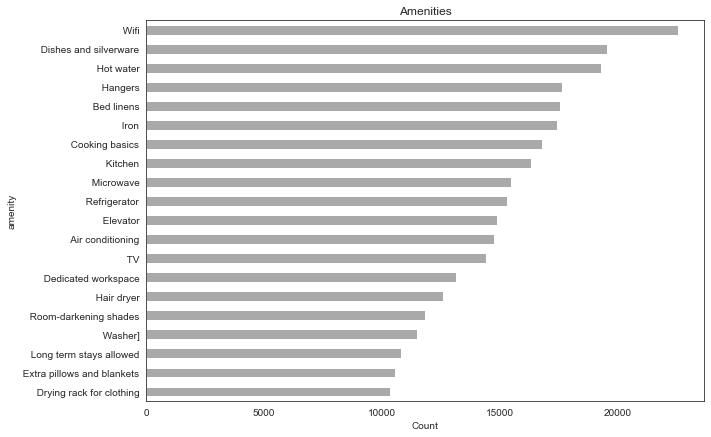

In [76]:
sub_df = pd.DataFrame(results.most_common(20), columns=['amenity', 'count'])
# plot the Top 20
sub_df.sort_values(by=['count'], ascending=True).plot(kind='barh', x='amenity', y='count',  
                                                      figsize=(10,7), legend=False, color='darkgrey',
                                                      title='Amenities')
plt.xlabel('Count');

In [78]:
listings['Dedicated_workspace'] = listings['amenities'].str.contains('Dedicated workspace')
listings['TV'] = listings['amenities'].str.contains('TV')
listings['Pets_allowed'] = listings['amenities'].str.contains('Pets allowed')
listings['Smoking_allowed'] = listings['amenities'].str.contains('Smoking allowed')
listings['Air_conditioning'] = listings['amenities'].str.contains('Air conditioning')
#listings['Parking'] = listings['amenities'].str.contains('Free parking on premises')

In [80]:
results2 = Counter()
listings['host_verifications'].str.strip('[]')\
               .str.replace(" ''", '')\
               .str.split(',')\
               .apply(results2.update)

results2

Counter({"'email'": 24396,
         " 'phone'": 24362,
         "'phone'": 3929,
         " 'work_email'": 1952,
         '': 9})

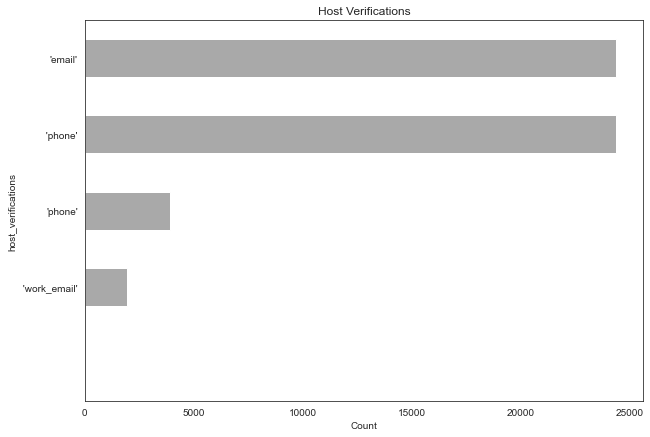

In [82]:
sub_df2 = pd.DataFrame(results2.most_common(10), columns=['host_verifications', 'count'])
sub_df2.sort_values(by=['count'], ascending=True).plot(kind='barh', x='host_verifications', y='count',  
                                                      figsize=(10,7), legend=False, color='darkgrey',
                                                      title='Host Verifications')
plt.xlabel('Count');

In [84]:
listings['email'] = listings['host_verifications'].str.contains('email')
listings['phone'] = listings['host_verifications'].str.contains('phone')


In [86]:
listings.head(2)

,host_has_profile_pic,host_identity_verified,host_id,host_verifications,neighbourhood_cleansed,latitude,longitude,price,minimum_nights,maximum_nights,...,room_type,accommodates,new_nei,Dedicated_workspace,TV,Pets_allowed,Smoking_allowed,Air_conditioning,email,phone
0,t,t,68997,"['email', 'phone']",Copacabana,-22.96599,-43.17940,310.0,5,28,...,Entire home/apt,5,Copacabana,False,True,False,True,True,True,True
1,t,t,102840,"['email', 'phone']",Copacabana,-22.97735,-43.19105,203.0,2,60,...,Entire home/apt,3,Copacabana,True,True,False,False,False,True,True


__Exploratory Data Analysis (EDA)__


__Step 9:__
Com o intuito de entender o comportamento dos precos, sera analisado por bairro, numero de quartos e banheiros,etc.

Text(0.5, 1.0, 'Distribuicao de preco pelas localidades (latitudexlongitude)')

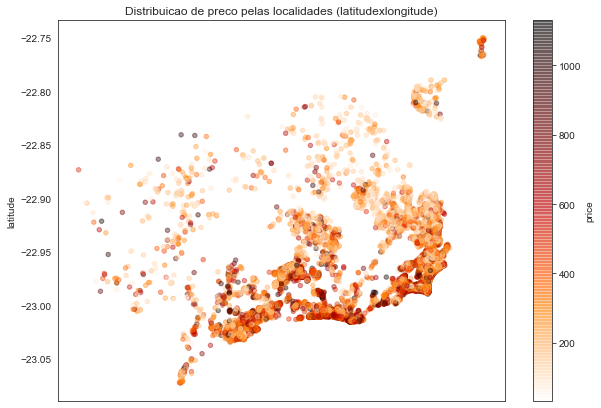

In [90]:
listings.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), 
        c="price", cmap="gist_heat_r", colorbar=True)

plt.title('Distribuicao de preco pelas localidades (latitudexlongitude)')

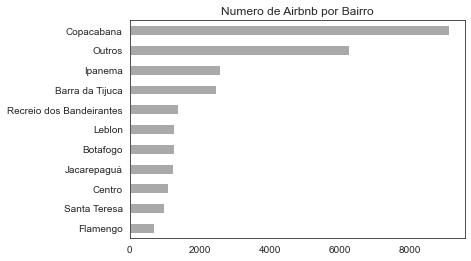

In [92]:
listings['new_nei'].value_counts().sort_values().plot(kind='barh', color='darkgrey')
plt.title('Numero de Airbnb por Bairro');

Text(0.5, 1.0, 'Densidade e distribuicao de precos por bairros')

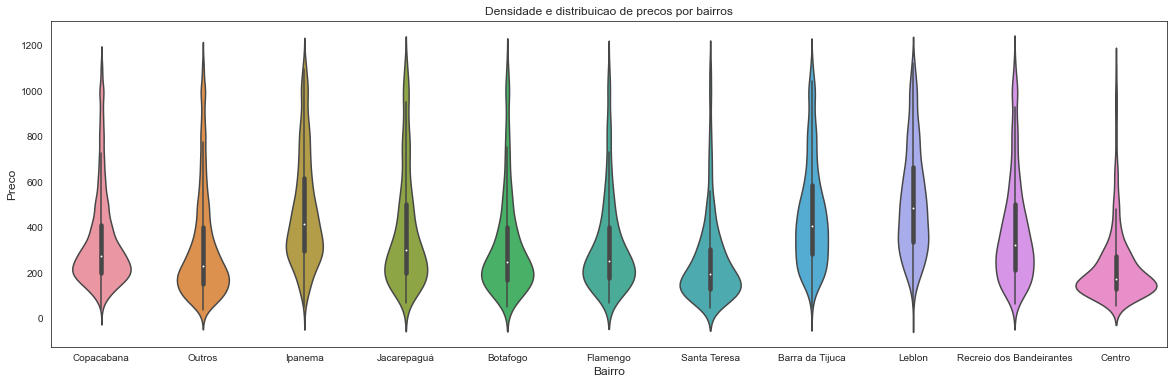

In [94]:
plt.figure(figsize=(20,6))
viz_2=sns.violinplot(data=listings, x='new_nei', y='price')
plt.xlabel('Bairro', fontsize=12)
plt.ylabel('Preco', fontsize=12)
viz_2.set_title('Densidade e distribuicao de precos por bairros')

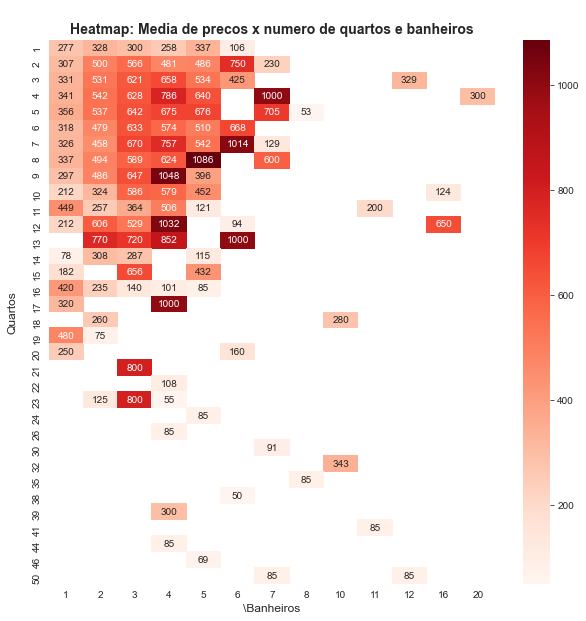

In [96]:
plt.figure(figsize=(10,10))
sns.heatmap(listings.groupby(['beds', 'bathrooms']).price.mean().unstack(), 
            cmap='Reds', annot=True, fmt=".0f")

plt.xlabel('\Banheiros', fontsize=12)
plt.ylabel('Quartos\n', fontsize=12)
plt.title('\nHeatmap: Media de precos x numero de quartos e banheiros', fontsize=14, fontweight='bold');

__Enconde__

__Step 10:__ 
Observa-se que possuimos variaveis, com preenchimento em texto e em varias categorias.
Portanto, iremos tranformar variaveis com 2 categorias em 0 e 1,e variaveis com mais categorias em dummie

In [98]:
df=listings.copy()

In [100]:
sorted(df)

['Air_conditioning',
 'Dedicated_workspace',
 'Pets_allowed',
 'Smoking_allowed',
 'TV',
 'accommodates',
 'amenities',
 'bathrooms',
 'bedrooms',
 'beds',
 'email',
 'host_has_profile_pic',
 'host_id',
 'host_identity_verified',
 'host_verifications',
 'instant_bookable',
 'latitude',
 'longitude',
 'maximum_nights',
 'minimum_nights',
 'neighbourhood_cleansed',
 'new_nei',
 'phone',
 'price',
 'property_type',
 'room_type']

In [114]:
df.instant_bookable.unique()

array([0, 1])

In [104]:
column_name=['Air_conditioning','Dedicated_workspace','Pets_allowed','Smoking_allowed','TV','email','phone']
df[column_name] = df[column_name].replace({False: 0, True: 1})

In [112]:
column_name=['host_identity_verified','instant_bookable']
df[column_name] = df[column_name].replace({'f': 0, 't': 1})

In [116]:
dummies=[
   'new_nei','room_type','property_type']
dummies=pd.get_dummies(df[dummies], drop_first=True)
dummies.shape
dummies.head()

,new_nei_Botafogo,new_nei_Centro,new_nei_Copacabana,new_nei_Flamengo,new_nei_Ipanema,new_nei_Jacarepaguá,new_nei_Leblon,new_nei_Outros,new_nei_Recreio dos Bandeirantes,new_nei_Santa Teresa,...,property_type_Shared room in hostel,property_type_Shared room in hotel,property_type_Shared room in loft,property_type_Shared room in rental unit,property_type_Shared room in tent,property_type_Shared room in tiny home,property_type_Shared room in townhouse,property_type_Shared room in vacation home,property_type_Tiny home,property_type_Treehouse
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [135]:
df=df.drop(['new_nei','host_has_profile_pic','host_identity_verified','host_id',
            'host_verifications','instant_bookable',
           'neighbourhood_cleansed','property_type','amenities','room_type',
            'latitude','longitude'
           ],axis=1)

In [137]:
df=pd.concat([df, dummies],axis=1)
df.head()

,price,minimum_nights,maximum_nights,bathrooms,beds,bedrooms,accommodates,Dedicated_workspace,TV,Pets_allowed,...,property_type_Shared room in hostel,property_type_Shared room in hotel,property_type_Shared room in loft,property_type_Shared room in rental unit,property_type_Shared room in tent,property_type_Shared room in tiny home,property_type_Shared room in townhouse,property_type_Shared room in vacation home,property_type_Tiny home,property_type_Treehouse
0,310.0,5,28,1,2,2,5,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,203.0,2,60,1,2,1,3,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,220.0,1,365,1,1,1,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,201.0,3,15,1,1,1,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,321.0,1,730,1,1,1,2,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [139]:
df.head()
df.shape
y=df['price']
y.head()
y.shape
X=df.drop(['price'],axis=1)


In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

__Feature Selection__

__Step 11:__ 
Para ter um bom modelo, precisamos 'escolher' as melhores variaveis.
Para 'escolher' as melhores variaveis iremos utilizar 4 tecnicas de selecao.
Após isso, iremos selecionar as 20 melhores de cada tecnica.

In [145]:
correlated_features = set()
correlation_matrix =X_train.corr(method ='spearman')
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
len(correlated_features)
print(correlated_features)

{'property_type_Room in boutique hotel', 'property_type_Farm stay', 'property_type_Private room in barn', 'property_type_Entire vacation home', 'property_type_Entire condo', 'property_type_Entire chalet', 'property_type_Private room in serviced apartment', 'property_type_Shared room in hostel', 'property_type_Shared room in townhouse', 'property_type_Private room in rental unit', 'property_type_Entire townhouse', 'property_type_Campsite', 'property_type_Shared room in bed and breakfast', 'property_type_Entire cottage', 'property_type_Private room in guesthouse', 'property_type_Hut', 'property_type_Entire home', 'property_type_Room in hostel', 'property_type_Shared room in castle', 'property_type_Private room in vacation home', 'property_type_Private room in tiny home', 'property_type_Entire villa', 'property_type_Tiny home', 'property_type_Shared room in rental unit', 'property_type_Room in hotel', 'property_type_Private room in cottage', 'new_nei_Flamengo', 'new_nei_Santa Teresa', 'pr

In [147]:
X_train.drop(labels=correlated_features, axis=1, inplace=True)
X_test.drop(labels=correlated_features, axis=1, inplace=True)

/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [152]:
np.isnan(df.any()) 
np.isfinite(df.all())

price                                               True
minimum_nights                                      True
maximum_nights                                      True
bathrooms                                           True
beds                                                True
bedrooms                                            True
accommodates                                        True
Dedicated_workspace                                 True
TV                                                  True
Pets_allowed                                        True
Smoking_allowed                                     True
Air_conditioning                                    True
email                                               True
phone                                               True
new_nei_Botafogo                                    True
new_nei_Centro                                      True
new_nei_Copacabana                                  True
new_nei_Flamengo               

In [149]:
mi = mutual_info_regression(X_train, y_train)
mi_df = pd.DataFrame(mi, index = X_train.columns, columns = ['mutual_information'])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
mi_top_features = mi_df.sort_values(by = 'mutual_information', ascending=False).head(20)
mi_top_features

In [ ]:
alpha = [0.1,0.15,0.2, 0.25, 0.275, 0.3, 0.325, 0.35]
a = np.zeros(shape=(len(X_train.columns),len(alpha)))
lasso_feature_coef_df = pd.DataFrame(a,columns=alpha,index=X_train.columns)
lasso_feature_coef_df

for a in alpha: 
    lasso = Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    
    lasso_feature_coef_df[a] = lasso.coef_


In [ ]:
lasso_top_features=lasso_feature_coef_df.sort_values(by = alpha, ascending=False).head(20)
lasso_top_features

In [ ]:
ridge = RidgeCV()
ridge.fit(X_train,y_train)
print("Best score using built-in LassoCV: %f" %ridge.score(X_train,y_train))
a=pd.Series(ridge.coef_, index = X_train.columns).index[:20]
a

In [ ]:
selected_features_lasso = lasso_top_features.index[:20].tolist()
selected_features_mi=mi_top_features.index[:20].tolist()
selected_features_ridge=pd.Series(ridge.coef_, index = X_train.columns).index[:20].tolist()
selected_features= set(selected_features_mi+selected_features_lasso+selected_features_ridge)
selected_features

__Modelagem__

__Step 12:__ 
Após a selecao das melhores variaveis explicativas,vamos aplicar tecnicas de machine learning para modelagem.

In [ ]:
X_train=X_train[selected_features]
X_test=X_test[selected_features]

In [ ]:
model_gb = GradientBoostingRegressor()
model_gb.fit(X_train, y_train)

print("Accuracy score (training): {0:.3f}".format(model_gb.score(X_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(model_gb.score(X_test, y_test)))

In [ ]:
min_max1 = MinMaxScaler().fit(X_train)
min_max1_X_train = min_max1.transform(X_train)
min_max1_X_test = min_max1.transform(X_test)
model_min_max1 = GradientBoostingRegressor().fit(min_max1_X_train, y_train)
model_min_max1.score(min_max1_X_test, y_test)

In [ ]:
scaler = StandardScaler().fit(X_train)
scaler_X_train = scaler.transform(X_train)
scaler_X_test = scaler.transform(X_test)
model_scaler = GradientBoostingRegressor().fit(scaler_X_train, y_train)
model_scaler.score(scaler_X_test, y_test)

In [ ]:
robust = RobustScaler().fit(X_train)
robust_X_train = robust.transform(X_train)
robust_X_test = robust.transform(X_test)
model_robust = GradientBoostingRegressor().fit(robust_X_train, y_train)
print(model_robust.score(robust_X_train, y_train))
print(model_robust.score(robust_X_test, y_test))

In [ ]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    model_gb = GradientBoostingRegressor(learning_rate=learning_rate)
    model_gb.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(model_gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(model_gb.score(X_test, y_test)))

__Step 14:__ 
Após aplicacao do algoritmo com diferente transformacoes. e depois com com n valores de learning rate, optou-se pelo modelo com learning rate:0.075.
Assim, a validacao sera feita baseada neste modelo.

In [ ]:
model_fin = GradientBoostingRegressor(learning_rate=0.075)
model_fin.fit(X_train, y_train)

In [ ]:
print("Accuracy score (training): {0:.3f}".format(model_fin.score(X_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(model_fin.score(X_test, y_test)))

In [ ]:
plt.figure(figsize=(10,10))
importances = model_fin.feature_importances_
indices = np.argsort(importances)[::-1]
sns.barplot(importances[indices][:20],X_train.columns[indices[:20]].values)
plt.title("Feature importances - GradientBoostingRegressor")

__Conclusion :__
Após a modelagem e selecao do melhor, realizamos a validacao - baseada na proporcao divida no treino e test.
Observando as variavies mais importantes do modelo, observa-se que: bedroon e variavel mais importante.

__Pontos de melhorias__ : 
Foi observado que variavel, metros quadrados (square feet), e discriminatoria do preço, mas tal variavel possui baixo preenchimento, nao sendo possivel tratar. Um proximo passo seria, o preenchimento correto deste campo, e a incorporacao desta variavel no modelo,